In [76]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
data_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Train")
print(classes)

['Validation', 'Test', 'Train']
['WithMask', 'WithoutMask']


In [78]:
train_ds = ImageFolder(data_dir+'/Train')
val_ds = ImageFolder(data_dir+'/Validation')
test_ds = ImageFolder(data_dir+'/Test')

In [79]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

10000
800
992


In [80]:
train_ds.classes

['WithMask', 'WithoutMask']

In [81]:
classes=["WithMask","WithoutMask"]

Label: WithMask


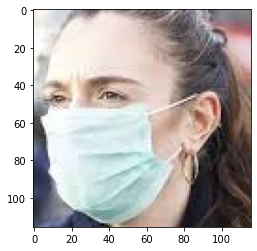

In [82]:
image, label = train_ds[6]
plt.imshow(image)
print('Label:',classes[label])

Label: WithMask


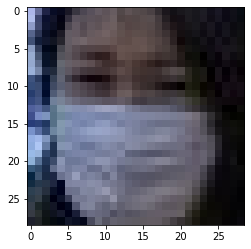

In [83]:
image, label = train_ds[588]
plt.imshow(image)
print('Label:',classes[label])

Label: WithoutMask


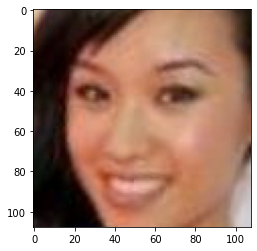

In [84]:
image, label = train_ds[5890]
plt.imshow(image)
print('Label:',classes[label])

Label: WithoutMask


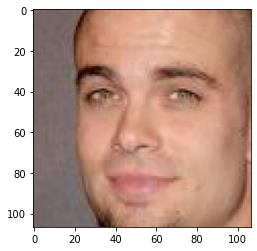

In [85]:
image, label = train_ds[7890]
plt.imshow(image)
print('Label:',classes[label])

**APPLYING TRANSFORMATIONS ON THE DATASET(RESIZING ALL THE IMAGES OF THE DATASET TO EQUAL SIZE(224X224) AND CONVERTING IT TO TENSORS**

In [86]:
import torchvision.transforms as transforms
train_tfms= tt.Compose([transforms.Resize(224),tt.ToTensor() ])
val_tfms= tt.Compose([transforms.Resize(224),tt.ToTensor()])
test_tfms= tt.Compose([transforms.Resize(224),tt.ToTensor()])
train_ds = ImageFolder(data_dir+'/Train', train_tfms)
val_ds = ImageFolder(data_dir+'/Validation', val_tfms)
test_ds = ImageFolder(data_dir+'/Test', test_tfms)

**CREATING DATALOADERS FOR SPLITTING A DATA INTO BATCHES FOR TRAINING PURPOSE**

In [87]:
# PyTorch data loaders
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

**LETS LOOK AT FEW EXAMPLES FROM OUR TRAINING DATA**

In [88]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

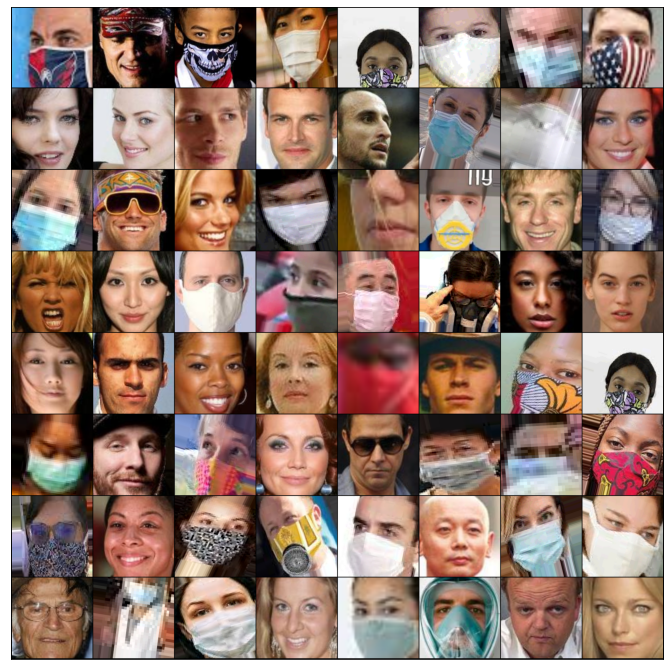

In [89]:
show_batch(train_loader)

In [90]:
img_tensor, label = train_ds[789]
print(img_tensor.shape, label)

torch.Size([3, 224, 224]) 0


Label (numeric): 0
Label (textual): WithMask


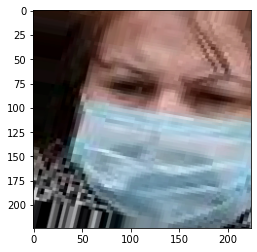

In [91]:
img, label = train_ds[1111]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

**FUNCTION FOR SELECTING THE AVAILABLE DEVICE(CPU OR GPU)**

In [92]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [93]:
device = get_default_device()
device

device(type='cuda')

**LETS DEFINE A DEVICE DATA LOADER TO MOVE OUR DATA TO THE SELECTED DEVICE**

In [94]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [95]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [96]:
input_size=3*224*224

**DEFINING THE MODEL**

In [97]:
class Dnn(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

**EXTEND THE DNN CLASS TO COMPLETE THE MODEL DEFINITION**

In [98]:
class Facemask(Dnn):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size,128)
        self.linear2 = nn.Linear(128,256)
        self.linear3 = nn.Linear(256,256)
        self.linear4 = nn.Linear(256,2)

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        return out

**DEFINING HELPER FUNCTIONS FOR TRAINING AND EVALUATION**

In [99]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [100]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**LETS INSTANTIATE THE MODEL**

In [101]:
model = to_device(Facemask(), device)

In [102]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.6943575143814087, 'val_acc': 0.4453125}]

**MODEL TRAINING**

In [103]:
history += fit(10,0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3962, val_acc: 0.8359
Epoch [1], val_loss: 0.4264, val_acc: 0.7935
Epoch [2], val_loss: 0.2358, val_acc: 0.9141
Epoch [3], val_loss: 0.2314, val_acc: 0.9040
Epoch [4], val_loss: 0.4113, val_acc: 0.8259
Epoch [5], val_loss: 0.1821, val_acc: 0.9286
Epoch [6], val_loss: 0.3072, val_acc: 0.8705
Epoch [7], val_loss: 0.4418, val_acc: 0.7121
Epoch [8], val_loss: 0.2316, val_acc: 0.8973
Epoch [9], val_loss: 0.1496, val_acc: 0.9464


In [104]:
history += fit(10,0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1428, val_acc: 0.9442
Epoch [1], val_loss: 0.1439, val_acc: 0.9453
Epoch [2], val_loss: 0.1311, val_acc: 0.9554
Epoch [3], val_loss: 0.1295, val_acc: 0.9464
Epoch [4], val_loss: 0.1289, val_acc: 0.9464
Epoch [5], val_loss: 0.1285, val_acc: 0.9475
Epoch [6], val_loss: 0.1214, val_acc: 0.9520
Epoch [7], val_loss: 0.1319, val_acc: 0.9498
Epoch [8], val_loss: 0.1249, val_acc: 0.9498
Epoch [9], val_loss: 0.1203, val_acc: 0.9509


In [105]:
history += fit(10,0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1198, val_acc: 0.9509
Epoch [1], val_loss: 0.1199, val_acc: 0.9509
Epoch [2], val_loss: 0.1191, val_acc: 0.9509
Epoch [3], val_loss: 0.1188, val_acc: 0.9498
Epoch [4], val_loss: 0.1184, val_acc: 0.9509
Epoch [5], val_loss: 0.1190, val_acc: 0.9509
Epoch [6], val_loss: 0.1179, val_acc: 0.9509
Epoch [7], val_loss: 0.1176, val_acc: 0.9509
Epoch [8], val_loss: 0.1171, val_acc: 0.9509
Epoch [9], val_loss: 0.1176, val_acc: 0.9509


In [106]:
evaluate(model, test_loader)

{'val_loss': 0.13547231256961823, 'val_acc': 0.9537760615348816}

**LETS MAKE SOME PREDICTIONS AND SEE HOW OUR MODEL PERFORMS ON TEST DATA**

In [107]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    xb = xb.to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: WithMask , Predicted: WithMask


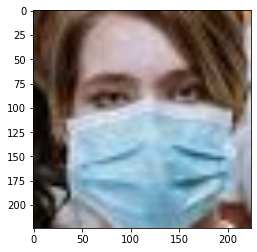

In [108]:
img, label = test_ds[8]
plt.imshow(img.permute((1, 2, 0)))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model)])

Label: WithoutMask , Predicted: WithoutMask


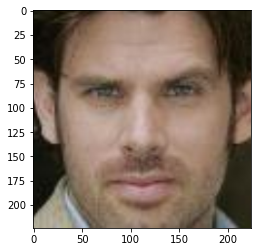

In [109]:
img, label = test_ds[500]
plt.imshow(img.permute((1, 2, 0)))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model)])

Label: WithMask , Predicted: WithMask


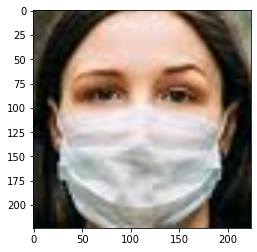

In [110]:
img, label = test_ds[49]
plt.imshow(img.permute((1, 2, 0)))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model)])

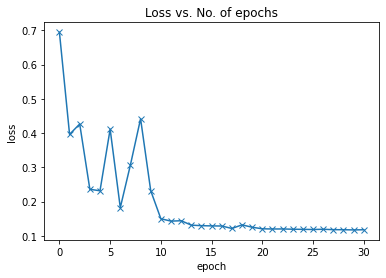

In [111]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

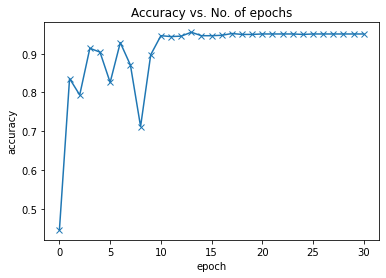

In [112]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

**PREDICTION ON IMAGES FROM MY PERSONAL DATA**

In [113]:
data_dir = '../input/images2'
print(os.listdir(data_dir))

['train']


In [114]:
train_ds = ImageFolder(data_dir+'/train')

In [115]:
import torchvision.transforms as transforms
train_tfms= tt.Compose([transforms.Resize((224,224)),tt.ToTensor() ])
train_ds = ImageFolder(data_dir+'/train', train_tfms)

In [116]:
batch_size=2
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [117]:
train_loader = DeviceDataLoader(train_loader, device)

Label: WithMask , Predicted: WithMask


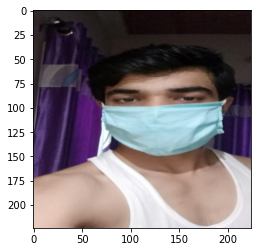

In [127]:
img,label=train_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model)])

In [128]:
!pip install jovian --upgrade --quiet
import jovian
project_name = 'face-mask-detection-neuralnet1'

<IPython.core.display.Javascript object>

In [129]:
torch.save(model.state_dict(), 'dnn.pth')

In [131]:
jovian.commit(project='face-mask-detection-neuralnet1', environment=None,outputs=['dnn.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/saurabhpalhade/face-mask-detection-neuralnet1


<IPython.core.display.Javascript object>